# Market Basket Analysis using PySpark's Implementation of FPGrowth

FPGrowth is an algorithm that performs market basket analysis, similar to the Apriori algorithm. I first used it when I ran into resource issues with Apriori and I was impressed with the speed. So I am giving it a try on this dataset using pyspark. The [documentation for FPGrowth](https://spark.apache.org/docs/latest/ml-frequent-pattern-mining.html) is pretty straightforward and describes the hyperparameters and the results.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/groceries-dataset-for-market-basket-analysismba/Groceries data.csv
/kaggle/input/groceries-dataset-for-market-basket-analysismba/basket.csv


In [2]:
!pip install pyspark
!pip install pyspark_dist_explore # Used for a histogram

     |████████████████████████████████| 281.3 MB 28 kB/s 
     |████████████████████████████████| 199 kB 58.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=934e11b6078a967e804742fcc2c802b246eaa61aad503650dfd6eccffc35817a
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


## Import the relevant libraries

The libraries such as SparkContext and SparkSession are general pyspark libraries needed for pyspark applications. The specific function used for market basket analysis is [FPGrowth](https://spark.apache.org/docs/latest/ml-frequent-pattern-mining.html). 

In [3]:
from pyspark import SparkContext
# Rather than generally using the functions, I should explicitly import the ones I want.
from pyspark.sql import functions as f, SparkSession, Column
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
from pyspark.ml.fpm import FPGrowth



## Create a spark session 

More info on [SparkSession.builder](https://spark.apache.org/docs/latest/sql-getting-started.html) for specific settings.

In [4]:
# Create a spark session. All sorts of settings can be specified here. 
spark = SparkSession.builder \
    .appName("arlUsingPyspark") \
    .getOrCreate()

# Read in the data 

I didn't end up using the ID number of the customer, but one thing that is important to know about pyspark dataframes is that they do not preserve order once they are sliced and diced. This dataset relies on the order of the two dataframes from the csv files having their order preserved, because the basket does not contain the customer ID number. Since I didn't need the customer ID number, I assigned a monotonically increasing ID number to each row as the file is read in. 

This monotonically increasing ID number is not sequential, so it cannot be used directly to match the rows of the two dataframes. If I had needed the customer ID number to be associated with the basket, I would have had to use a window function over the ID number to create an index, and then match on the index. 

In [5]:
df = spark.read.csv("/kaggle/input/groceries-dataset-for-market-basket-analysismba/basket.csv", header=True).withColumn("id", f.monotonically_increasing_id())
df_all = spark.read.csv("/kaggle/input/groceries-dataset-for-market-basket-analysismba/Groceries data.csv", header=True).withColumn("id", f.monotonically_increasing_id())

In [6]:
# Show is pyspark's version of head(), although it can be slow so I do try to skip this. 
df.show(5)
df_all.show(5)

+-----------+------------------+-------------------+------+----+----+----+----+----+----+----+---+
|          0|                 1|                  2|     3|   4|   5|   6|   7|   8|   9|  10| id|
+-----------+------------------+-------------------+------+----+----+----+----+----+----+----+---+
| whole milk|            pastry|        salty snack|  null|null|null|null|null|null|null|null|  0|
|    sausage|        whole milk|semi-finished bread|yogurt|null|null|null|null|null|null|null|  1|
|       soda|pickled vegetables|               null|  null|null|null|null|null|null|null|null|  2|
|canned beer|   misc. beverages|               null|  null|null|null|null|null|null|null|null|  3|
|    sausage|  hygiene articles|               null|  null|null|null|null|null|null|null|null|  4|
+-----------+------------------+-------------------+------+----+----+----+----+----+----+----+---+
only showing top 5 rows

+-------------+----------+----------------+----+-----+---+-----------+---+
|Member_n

## printSchema() shows the structure of the Spark dataframe

This is a really useful debugging tool and one of the first things I look at when I get into trouble.

In [7]:
# printSchema() shows the structure of the dataframe. This is important for debugging.
df.printSchema()
df_all.printSchema()

root
 |-- 0: string (nullable = true)
 |-- 1: string (nullable = true)
 |-- 2: string (nullable = true)
 |-- 3: string (nullable = true)
 |-- 4: string (nullable = true)
 |-- 5: string (nullable = true)
 |-- 6: string (nullable = true)
 |-- 7: string (nullable = true)
 |-- 8: string (nullable = true)
 |-- 9: string (nullable = true)
 |-- 10: string (nullable = true)
 |-- id: long (nullable = false)

root
 |-- Member_number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- itemDescription: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- id: long (nullable = false)



# How many baskets are there per customer? 

I wanted to look at the number of baskets each customer had in the dataset. This can tell you if your dataset is appropriate for market basket analysis. They have to have baskets or there will be no data to match on.

In [8]:
num_baskets = df_all.groupBy("Member_number").count()
num_baskets.show(5)

+-------------+-----+
|Member_number|count|
+-------------+-----+
|         2904|   10|
|         3959|   14|
|         2294|   23|
|         4032|    4|
|         1512|   10|
+-------------+-----+
only showing top 5 rows



# The distribution of the number of baskets

Create a histogram of the number of baskets using pyspark_dist_explore. This library can create some fast visualizations on a pyspark dataframe, similar to matplotlib. 

(array([302., 328., 178., 371., 237., 341., 251., 538., 252., 192., 179.,
        144., 136., 109.,  69., 110.,  49.,  23.,  29.,  14.,  11.,   9.,
         13.,   4.,   1.,   4.,   0.,   3.,   0.,   1.]),
 array([ 2.        ,  3.13333333,  4.26666667,  5.4       ,  6.53333333,
         7.66666667,  8.8       ,  9.93333333, 11.06666667, 12.2       ,
        13.33333333, 14.46666667, 15.6       , 16.73333333, 17.86666667,
        19.        , 20.13333333, 21.26666667, 22.4       , 23.53333333,
        24.66666667, 25.8       , 26.93333333, 28.06666667, 29.2       ,
        30.33333333, 31.46666667, 32.6       , 33.73333333, 34.86666667,
        36.        ]),
 <BarContainer object of 30 artists>)

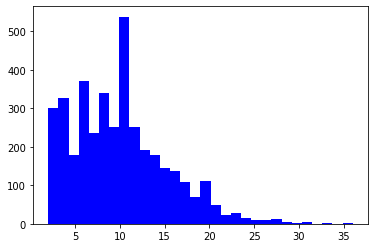

In [9]:
fig, ax = plt.subplots()

hist(ax, num_baskets.select('count'), bins = 30, color=['blue'])

# Run PySpark's implementation of FPGrowth

First step is to collect the baskets into sets. FPGrowth requires each basket to be an array that looks like:

* ['item1','item2', 'imem3']

The basket dataframe uses wide rather than long format, with Null if the basket contains fewer than 10 items. 

In [10]:
df_basket = df.select("id", f.array([df[c] for c in df.columns[:11]]).alias("basket"))
df_basket.printSchema()
# False tells show() to not truncate the columns when printing.
df_basket.show(3, False) 

root
 |-- id: long (nullable = false)
 |-- basket: array (nullable = false)
 |    |-- element: string (containsNull = true)

+---+--------------------------------------------------------------------------------------------+
|id |basket                                                                                      |
+---+--------------------------------------------------------------------------------------------+
|0  |[whole milk, pastry, salty snack, null, null, null, null, null, null, null, null]           |
|1  |[sausage, whole milk, semi-finished bread, yogurt, null, null, null, null, null, null, null]|
|2  |[soda, pickled vegetables, null, null, null, null, null, null, null, null, null]            |
+---+--------------------------------------------------------------------------------------------+
only showing top 3 rows



### There should not be any nulls in the array. Remove using array_except()

This will be the final dataframe used for FPGrowth. 

In [11]:
df_aggregated = df_basket.select("id", f.array_except("basket", f.array(f.lit(None))).alias("basket"))
df_aggregated.show(3, False)

+---+--------------------------------------------------+
|id |basket                                            |
+---+--------------------------------------------------+
|0  |[whole milk, pastry, salty snack]                 |
|1  |[sausage, whole milk, semi-finished bread, yogurt]|
|2  |[soda, pickled vegetables]                        |
+---+--------------------------------------------------+
only showing top 3 rows



## Hyperparameters

The hyperparameters used in FPGrowth are minimum support, minimum confidence, and number of partitions. 

* minSupport - The minimum support of an item to be considered in a frequent itemset. 
* minConfidence - The minimum confidence for generating an association rule from an itemset. 
* numPartitions - The number of partitions used to distribute the work. This is Spark-specific. 

The default number of partitions is the number of partitions for the input dataset. 

In [12]:
# Run FPGrowth and fit the model.
fp = FPGrowth(minSupport=0.001, minConfidence=0.001, itemsCol='basket', predictionCol='prediction')
model = fp.fit(df_aggregated)

In [13]:
# View a subset of the frequent itemset. 
model.freqItemsets.show(10, False)

+------------------------+----+
|items                   |freq|
+------------------------+----+
|[cocoa drinks]          |16  |
|[canned fruit]          |21  |
|[specialty cheese]      |72  |
|[chocolate marshmallow] |60  |
|[pet care]              |85  |
|[house keeping products]|45  |
|[jam]                   |34  |
|[light bulbs]           |29  |
|[beef]                  |508 |
|[beef, frankfurter]     |15  |
+------------------------+----+
only showing top 10 rows



In [14]:
# Use filter to view just the association rules with the highest confidence.
model.associationRules.filter(model.associationRules.confidence>0.15).show(20, False)

+---------------------+------------+-------------------+------------------+---------------------+
|antecedent           |consequent  |confidence         |lift              |support              |
+---------------------+------------+-------------------+------------------+---------------------+
|[bottled beer]       |[whole milk]|0.15781710914454278|0.9993302598941151|0.007150972398583172 |
|[detergent]          |[whole milk]|0.16279069767441862|1.030824041177455 |0.001403461872619127 |
|[semi-finished bread]|[whole milk]|0.176056338028169  |1.1148247930239072|0.001670787943594199 |
|[sausage, rolls/buns]|[whole milk]|0.2125             |1.345593525179856 |0.0011361358016440553|
|[sausage, soda]      |[whole milk]|0.1797752808988764 |1.1383739010113787|0.0010693042839002875|
|[ham]                |[whole milk]|0.16015625         |1.0141421789039358|0.0027400922274944863|
|[frozen fish]        |[whole milk]|0.1568627450980392 |0.9932870312746344|0.0010693042839002875|
|[sausage, whole mil

## Let's create a prediction based on the generated association rules

This is pretty similar to creating a prediction using other methods. The data column needs to have the same column name as the column specified in the model fit.

In [15]:
# Create a PySpark dataframe
columns = ['basket']
new_data = [(['ham', 'yogurt', 'light bulbs'],), (['jam', 'cocoa drinks', 'pet care'],)]
rdd = spark.sparkContext.parallelize(new_data)
new_df = rdd.toDF(columns)
new_df.printSchema()
new_df.show(2,False)

root
 |-- basket: array (nullable = true)
 |    |-- element: string (containsNull = true)

+-----------------------------+
|basket                       |
+-----------------------------+
|[ham, yogurt, light bulbs]   |
|[jam, cocoa drinks, pet care]|
+-----------------------------+



# Predict!

Now that we have a new PySpark dataframe with data, predict. The first basket generates numerous predictions based on the association rules, however the second basket does not generate any. 

In [16]:
model.transform(new_df).show(5, False)

+-----------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|basket                       |prediction                                                                                                                                                                                                                                                                                                             